In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.io import loadmat
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm
import time
import itertools
import os
from pathlib import Path
import proplot as pplt

figwidth=3.25
figheight=figwidth*3/4
figwidth_2col=7

In [2]:
def assemble_cap_matrix(material,matfilename):
    start = time.time()
    print(f'loading {material} data')
    
    rawmat = loadmat(os.getcwd() + f'/{material}/{matfilename}_1.mat')
    
    pathinfo = pd.DataFrame(rawmat['pathinfo'],columns = ['LLI','LAMPE','LAMNE','Capacity_Loss'])/100
    values = list(rawmat['Cell_info'][0])
    keys = ['Positive electrode','Negative electrode','LR','OFS','Resistance adjustment',
        '2nd positive electrode if blended electrode','2nd negative electrode if blended electrode',
        '% of PE1', '% of NE1']
    cellinfo = dict(zip(keys, values))
    Qnorm = rawmat['Qnorm'].reshape(len(rawmat['Qnorm']))
    Vrange = np.array([rawmat['Vnorm'].min(),rawmat['Vnorm'].max()])
    V_discrete = np.arange(Vrange[0],Vrange[1],1/1000)

    f = interp1d(rawmat['volt_part1'].T[0],Qnorm,bounds_error=False,fill_value=(0,Qnorm.max()))
    Q0 = f(V_discrete)
    
    cookedvolt = rawmat['volt_part1']
    
    for i in [2,3]:
        rawmat = loadmat(os.getcwd() + f'/{material}/{matfilename}_{i}.mat')
        cookedvolt = np.concatenate((cookedvolt,rawmat['volt_part'+str(i)]),axis=1)
        
    duration = time.time() - start
    print(f'loading {material} data took {int(duration)} s')
    
    
        
    return {'cellinfo':cellinfo,'pathinfo':pathinfo,'volt':cookedvolt,'Qnorm':Qnorm,'V_discrete':V_discrete,'Q0':Q0}

In [3]:
filename_dict = {'LFP':'Gr-LFP_5000paths','NCA':'Gr-NCA_Co33_cha','NMC':'Gr-NMC811_Co25_cha'}
materials = list(filename_dict.keys())

all_data = {}
for material,material_filename in filename_dict.items():
    if material =='NMC':
        all_data[material] = assemble_cap_matrix(material,material_filename)


loading NMC data
loading NMC data took 22 s


In [4]:
from scipy.spatial import KDTree
def closest_sims(y,pathinfo):
    kdtree=KDTree(pathinfo.values[:,:3])
    dist,points=kdtree.query(y.values[:,:3],1)
    return pathinfo.loc[points,:]

In [9]:
for material,mat_data in all_data.items():
    print(f'making sets for {material}')
    pathinfo = mat_data['pathinfo']
    
    start = time.time()
    iteration_lists = []
    for i in range(3):
        iteration_lists.append(list(np.arange(0,0.8,0.05)))

    grid_samples_train = list(itertools.product(iteration_lists[0],iteration_lists[1],iteration_lists[2]))
    y_test2 = pd.DataFrame(grid_samples_train,columns=pathinfo.columns[:3])

    mat_data['y_train'] = closest_sims(y_test2,pathinfo)
    print(f'   making train set took {int(time.time()-start)}s')
    
    start = time.time()
    iteration_lists = []
    for i in range(3):
        iteration_lists.append(list(np.arange(0,0.8,0.025)))

    grid_samples_train = list(itertools.product(iteration_lists[0],iteration_lists[1],iteration_lists[2]))
    y_test2 = pd.DataFrame(grid_samples_train,columns=pathinfo.columns[:3])

    mat_data['y_test'] = closest_sims(y_test2,pathinfo)
    print(f'   making test set took {int(time.time()-start)}s')
    
    

making sets for NMC
   making train set took 3s
   making test set took 8s


In [10]:
def scrub_nans(profile,Qnorm):
    Qnorm_cut = Qnorm[~np.isnan(profile)]
    profile_cut = profile[~np.isnan(profile)]
    return Qnorm_cut, profile_cut

def calc_IC(Q,V):
    return V[1:] - np.diff(V),np.diff(Q)/np.diff(V)

def calc_DV(Q,V):
    return Q[1:] - np.diff(V), np.diff(V)/np.diff(Q)

In [11]:
for material,mat_data in all_data.items():
    
    y_train = mat_data['y_train']
    y_test = mat_data['y_test']

    print(f'processing {material} profiles')
    pathinfo = mat_data['pathinfo']
    Qnorm = mat_data['Qnorm']
    V_discrete = mat_data['V_discrete']
    Q0 = mat_data['Q0']
    deltaQs = np.empty((len(pathinfo),len(V_discrete)))* np.nan
    ICs = np.empty((len(pathinfo),len(V_discrete)-1))* np.nan
    DVs = np.empty((len(pathinfo),len(Qnorm)-1))* np.nan

    start = time.time()
    for i in y_train.index:
        Qnorm_cut,profile_cut = scrub_nans(mat_data['volt'].T[i],Qnorm)
        f = interp1d(profile_cut,Qnorm_cut,bounds_error=False,fill_value=(0,Qnorm_cut.max()))
        deltaQs[i,:] = f(V_discrete) - Q0
        ICs[i,:] = calc_IC(f(V_discrete),V_discrete)[1]
        DVs[i,:] = calc_DV(Qnorm,mat_data['volt'].T[i])[1]
    print(f'   processing training set took {int(time.time()-start)}s')
    
    start = time.time()
    for i in y_test.index:
        Qnorm_cut,profile_cut = scrub_nans(mat_data['volt'].T[i],Qnorm)
        f = interp1d(profile_cut,Qnorm_cut,bounds_error=False,fill_value=(0,Qnorm_cut.max()))
        deltaQs[i,:] = f(V_discrete) - Q0
        ICs[i,:] = calc_IC(f(V_discrete),V_discrete)[1]
        DVs[i,:] = calc_DV(Qnorm,mat_data['volt'].T[i])[1]
    print(f'   processing test set 1 took {int(time.time()-start)}s')
    
            
    mat_data['transformed_profiles'] = {'deltaQ':deltaQs,'IC':ICs,'DV':DVs}

processing NMC profiles
   processing training set took 2s
   processing test set 1 took 16s


In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler,MaxAbsScaler

In [14]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

def regression_accuracy(model,X,y):
    y_pred = model.predict(X)
    RMSEs = []
    for i,p in enumerate(range(len(y.T))):
        RMSEs.append(np.sqrt(mean_squared_error(y[:,i],y_pred[:,i])))
    return RMSEs

def regression_accuracy2(model,X,y):
    y_pred = model.predict(X)
    MAEs = []
    for i,p in enumerate(range(len(y.T))):
        MAEs.append(MAE(y[:,i],y_pred[:,i]))
    return MAEs

def RMSE(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

def MAPE(y_true,y_pred):
    return np.nanmean(np.abs((y_pred-y_true)/y_true))

def MAE(y_true,y_pred):
    return np.nanmean(np.abs(y_pred-y_true))

def dummify(df):   
        
    df['PElim'] = np.zeros(len(df))
    df['plating'] = np.zeros(len(df))
    
    df.loc[df.OFS <0, 'PElim'] = 1
    df.loc[df.LAMNE > df.PT, 'plating'] = 1
        
    return df

from sklearn.metrics import confusion_matrix

def evaluate_classifier(y,X,model,make_dummy=False,material=None):
    
    y = dummify(y)

    if make_dummy:
        y_pred = pd.DataFrame(model.predict(X),columns=y.columns[:3])
        y_pred = make_groups(y_pred,material)
        y_pred = dummify(y_pred)
    else:
        y_pred = pd.DataFrame(model.predict(X),columns=['PElim','plating'])        

    results_dict = {}
    for i,p in enumerate(['PElim','plating']):
        conf_matrix_flat = confusion_matrix(y.loc[:,p], y_pred.loc[:,p]).reshape(4,)
        results_dict[p] = conf_matrix_flat
            
            
    results = pd.DataFrame(results_dict,index=['TN','FP','FN','TP']).T
    results = add_descriptors(results)
    return results

def evaluate_hamming_loss(results):
    return (results.sum(axis=0)['FP'] + results.sum(axis=0)['FN'])/results.sum(axis=0)['T']

def add_descriptors(confusion_df):
    confusion_df['T'] = confusion_df.sum(axis=1)
    confusion_df['ACC'] = (confusion_df['TP'] + confusion_df['TN'])/confusion_df['T']
    confusion_df['TPR'] = confusion_df['TP']/(confusion_df['TP']+confusion_df['FN'])
    confusion_df['TNR'] = confusion_df['TN']/(confusion_df['TN']+confusion_df['FP'])
    confusion_df['FPR'] = 1-confusion_df['TNR']
    confusion_df['FNR'] = 1-confusion_df['TPR']
    return confusion_df

In [30]:
regression_model_dict = {'Random Forrest Regressor': RandomForestRegressor(),
                        }
linear_coeff_ovr = ['Logistic Regression','Logistic Regression (Elastic Net)','Linear Discriminant Analysis']
linear_coeff_multioutput = ['Linear Regression','Elastic Net']
tree_based = ['Decision Tree Regressor','Random Forrest Regressor','Decision Tree Classifier','Random Forrest Classifier','AdaBoost Classifier']


In [38]:
materials = list(all_data.keys())
preprocessing = ['IC']
models = ['Random Forrest Regressor']
n_points = [20,40,80,160]

ml_experiments = pd.DataFrame(list(itertools.product(materials,preprocessing,models,n_points)))
ml_experiments.columns = ['material','preprocessing','model_name','n_points']
ml_experiments['classification'] = [False]*len(ml_experiments)
ml_experiments = ml_experiments[['material','preprocessing','model_name','classification','n_points']]
# ml_experiments.loc[ml_experiments['model_name'].isin(list(regression_model_dict.keys())),'classification'] = False
ml_experiments['exp_id'] = ml_experiments.index
ml_experiments

,material,preprocessing,model_name,classification,n_points,exp_id
0,NMC,IC,Random Forrest Regressor,False,20,0
1,NMC,IC,Random Forrest Regressor,False,40,1
2,NMC,IC,Random Forrest Regressor,False,80,2
3,NMC,IC,Random Forrest Regressor,False,160,3


In [28]:
class ML_exp:
    
    def __init__(self,material,preprocessing,model_name,classification):
        self.material = material
        self.preprocessing = preprocessing
        self.model_name = model_name
        self.classification = classification
        self.model = None
        self.results = {'regression':{'Train':{}},'classification':{}}
        self.prediction = {'regression':{},'classification':{}}
        self.prediction_prob = {}
        self.fitted = False
        self.fit_time = None
        self.coef = None
        
    def fit_model(self,X_train,y_train):
        if self.classification:
            mod = classification_model_dict[self.model_name]
            start = time.time()
            self.model = mod.fit(X_train,y_train.loc[:,['PElim','plating']])
            self.fitted=True
            self.results['classification']['Train'] = evaluate_classifier(y_train,X_train,self.model,make_dummy=False)
            self.prediction['classification']['Train'] = self.model.predict(X_train)
            self.prediction_prob['Train'] = self.model.predict_proba(X_train)
            if self.model_name in linear_coeff_ovr:
                self.coef = [self.model.estimators_[j].coef_[0] for j in range(2)]
            elif self.model_name in tree_based[:-1]:
                self.coef = self.model.feature_importances_
            elif self.model_name == 'AdaBoost Classifier':
                self.coef = [self.model.estimators_[j].feature_importances_ for j in range(2)]
            else:
                self.coef = None
            self.fit_time = time.time() - start
            
        else:
            mod = regression_model_dict[self.model_name]
            start = time.time()
            self.model = mod.fit(X_train,y_train.iloc[:,:3])
            self.fitted=True
            self.results['regression']['Train']['RMSE'] = regression_accuracy(self.model,X_train,y_train.values[:,:3])
            self.results['regression']['Train']['MAE'] = regression_accuracy2(self.model,X_train,y_train.values[:,:3])
#             self.results['classification']['Train'] = evaluate_classifier(y_train,X_train,self.model,make_dummy=True,material=self.material)
#             self.prediction['regression']['Train'] = self.model.predict(X_train)
#             self.prediction['classification']['Train'] = dummify(make_groups(pd.DataFrame(self.model.predict(X_train),columns=y_train.columns[:3]),self.material))
            if self.model_name in linear_coeff_multioutput:
                self.coef = [self.model.estimators_[j].coef_ for j in range(3)]
            elif self.model_name in tree_based:
                self.coef = self.model.feature_importances_
            else:
                self.coef = None
            self.fit_time = time.time() - start
            
    def test_model(self,X_test,y_test,lab):
        if not self.fitted:
            raise ValueError('Model has not been fitted!')
            
        if self.classification:
            self.results['classification'][lab] = evaluate_classifier(y_test,X_test,self.model,make_dummy=False)
            self.prediction['classification'][lab] = self.model.predict(X_test)
            self.prediction_prob[lab] = self.model.predict_proba(X_test)
        else:
            self.results['regression'][lab] = {}
            self.results['regression'][lab]['RMSE'] = regression_accuracy(self.model,X_test,y_test.values[:,:3])
            self.results['regression'][lab]['MAE'] = regression_accuracy2(self.model,X_test,y_test.values[:,:3])
#             self.results['classification'][lab] = evaluate_classifier(y_test,X_test,self.model,make_dummy=True,material=self.material)
#             self.prediction['regression'][lab] = self.model.predict(X_test)
#             self.prediction['classification'][lab] = dummify(make_groups(pd.DataFrame(self.model.predict(X_test),columns=y_train.columns[:3]),self.material))


In [23]:
# n_points = 20

def rescale_and_featurize(n_points):
    for material,mat_data in all_data.items():
        print(f'rescaling {material} profiles')

        mat_data['rescaled_profiles'] = {}

        for processing,processed_data in mat_data['transformed_profiles'].items():

            mat_data['rescaled_profiles'][processing] = {}
            mat_data['rescaled_profiles']['all_features'] = {}
            for ylab,Xlab in zip(['y_train','y_test'],['X_train','X_test']):
                X = processed_data[mat_data[ylab].index]

                if Xlab=='X_train':
                    scaler = MinMaxScaler().fit(X)

                X = scaler.transform(X)
                idx = [np.round(np.linspace(0, len(X.T) - 1, n_points)).astype(int)]
                X = X.T[idx,:].T.reshape(len(X),n_points)

                mat_data['rescaled_profiles'][processing][Xlab] = np.nan_to_num(X)


        for Xlab in ['X_train','X_test']:
            all_features = [mat_data['rescaled_profiles'][processing][Xlab] for preprocessing in mat_data['transformed_profiles'].keys()]
            mat_data['rescaled_profiles']['all_features'][Xlab] = np.concatenate(all_features,axis=1)
            
    return all_data
      

In [39]:
experiments = []
for i in tqdm(ml_experiments.index):
    
    rescale_and_featurize(ml_experiments.loc[i,'n_points'])
        
    exp_params = dict(ml_experiments.loc[i,['material','preprocessing','model_name','classification']])
    exp = ML_exp(**exp_params)

    X_train = all_data[exp_params['material']]['rescaled_profiles'][exp_params['preprocessing']]['X_train']
    print(np.shape(X_train))
    y_train = all_data[exp_params['material']]['y_train']

    exp.fit_model(X_train,y_train)
    
    X_test = all_data[exp_params['material']]['rescaled_profiles'][exp_params['preprocessing']]['X_test']
    y_test = all_data[exp_params['material']]['y_test']

    exp.test_model(X_test,y_test,'Test')

    experiments.append(exp)

rescaling NMC profiles
(4096, 20)
rescaling NMC profiles
(4096, 40)
rescaling NMC profiles
(4096, 80)
rescaling NMC profiles
(4096, 160)



Text(20, 3, 'Train')

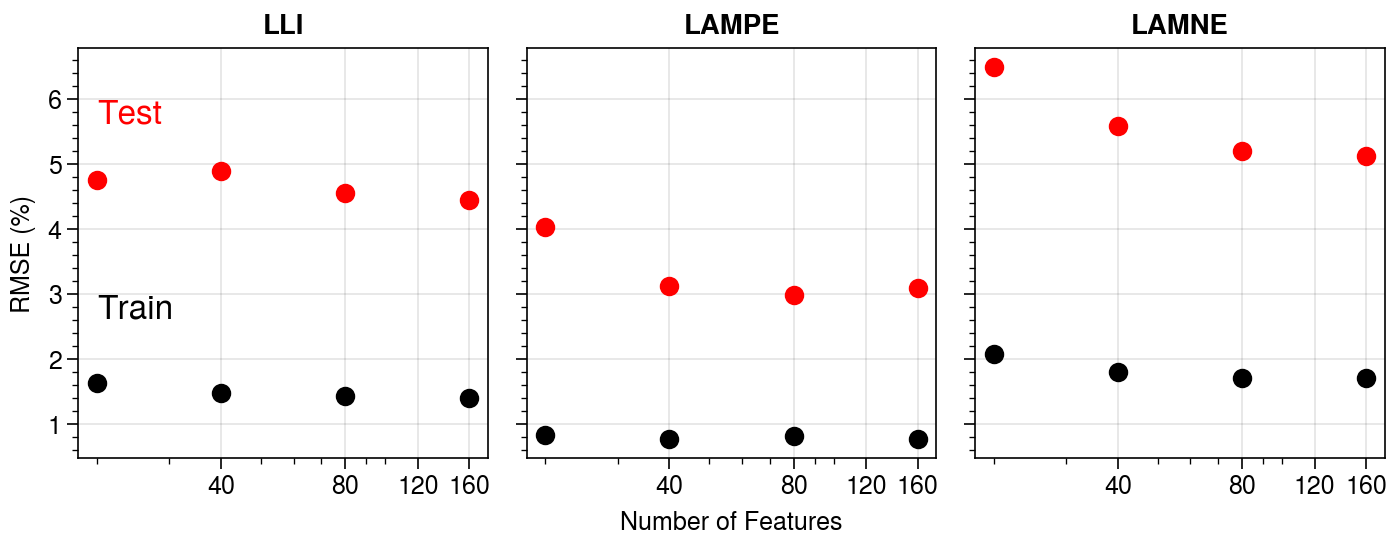

In [66]:
fig,axs = pplt.subplots(nrows=1,ncols=3,width=figwidth_2col,facecolor='w')#,sharey=False)
for i,ax in enumerate(axs):
    for j,n_points in enumerate(ml_experiments.n_points):
        exp = experiments[j]
        ax.plot(n_points,100*exp.results['regression']['Train']['RMSE'][i],'ok')
        ax.plot(n_points,100*exp.results['regression']['Test']['RMSE'][i],'or')

axs.format(xscale='log', xlocator=('maxn', 4),
           xlabel='Number of Features',ylabel='RMSE (%)',
           collabels=list(pathinfo.columns[:3]))

axs[0].text(20,6,'Test',color='red',fontsize=12,va='top')
axs[0].text(20,3,'Train',color='k',fontsize=12,va='top')